In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import ElasticNetCV,ElasticNet,enet_path
from sklearn.datasets import make_regression
from redcap import Project

In [2]:
# # Import data from REDCap
# api_url = 'https://redcap.ucdenver.edu/api/'
# api_key = ''
# project = Project(api_url, api_key)
# data = project.export_records(forms=['parent_demographics'])

# ElasticNet

In [3]:
# Import data
df = pd.read_csv('/Users/timvigers/Downloads/177844RenalBloodFlow_DATA_2021-12-13_1220.csv')
# Predictors
r_rbf_avg = df[['r_rbf_avg_sr','r_rbf_avg_sup_sr','r_rbf_avg_inf_sr','r_rbf_avg_3b_sr']].sum(axis=1)
r_rbf_avg[r_rbf_avg == 0] = np.nan
r_rbf_avg_vein = df[['r_rbf_avg_vein_sr','r_rbf_avg_vein_sup_sr','r_rbf_avg_vein_inf_sr']].sum(axis=1)
r_rbf_avg_vein[r_rbf_avg_vein == 0] = np.nan
l_rbf_avg = df[['l_rbf_avg_sr','l_rbf_avg_sup_sr','l_rbf_avg_inf_sr','l_rbf_avg_3b_sr']].sum(axis=1)
l_rbf_avg[l_rbf_avg == 0] = np.nan
l_rbf_avg_vein = df[['l_rbf_avg_vein_sr','l_rbf_avg_vein_sup_sr','l_rbf_avg_vein_inf_sr']].sum(axis=1)
l_rbf_avg_vein[l_rbf_avg_vein == 0] = np.nan
r_rbf_peak = df[['r_rbf_peak_sr','r_rbf_peak_sup_sr','r_rbf_peak_inf_sr','r_rbf_peak_3b_sr']].sum(axis=1)
r_rbf_peak[r_rbf_peak == 0] = np.nan
r_rbf_peak_vein = df[['r_rbf_peak_vein_sr','r_rbf_peak_vein_sup_sr','r_rbf_peak_vein_inf_sr']].sum(axis=1)
r_rbf_peak_vein[r_rbf_peak_vein == 0] = np.nan
l_rbf_peak = df[['l_rbf_peak_sr','l_rbf_peak_sup_sr','l_rbf_peak_inf_sr','l_rbf_peak_3b_sr']].sum(axis=1)
l_rbf_peak[l_rbf_peak == 0] = np.nan
l_rbf_peak_vein = df[['l_rbf_peak_vein_sr','l_rbf_peak_vein_sup_sr','l_rbf_peak_vein_inf_sr']].sum(axis=1)
l_rbf_peak_vein[l_rbf_peak_vein == 0] = np.nan
r_rbv_peak = df[['r_rbv_peak_sr','r_rbv_peak_sup_sr','r_rbv_peak_inf_sr','r_rbv_peak_3b_sr']].sum(axis=1)
r_rbv_peak[r_rbv_peak == 0] = np.nan
r_rbv_peak_vein = df[['r_rbv_peak_vein_sr','r_rbv_peak_vein_sup_sr','r_rbv_peak_vein_inf_sr']].sum(axis=1)
r_rbv_peak_vein[r_rbv_peak_vein == 0] = np.nan
l_rbv_peak = df[['l_rbv_peak_sr','l_rbv_peak_sup_sr','l_rbv_peak_inf_sr','l_rbv_peak_3b_sr']].sum(axis=1)
l_rbv_peak[l_rbv_peak == 0] = np.nan
l_rbv_peak_vein = df[['l_rbv_peak_vein_sr','l_rbv_peak_vein_sup_sr','l_rbv_peak_vein_inf_sr']].sum(axis=1)
l_rbv_peak_vein[l_rbv_peak_vein == 0] = np.nan
# eGFR
eGFR_schwartz = round(0.413*(df.ht/df.screat),2)
# Put together
calculated = {'r_rbf_avg':r_rbf_avg,'r_rbf_avg_vein':r_rbf_avg_vein,'l_rbf_avg':l_rbf_avg,
              'l_rbf_avg_vein':l_rbf_avg_vein,'r_rbf_peak':r_rbf_peak,'r_rbf_peak_vein':r_rbf_peak_vein,
             'l_rbf_peak':l_rbf_peak,'l_rbf_peak_vein':l_rbf_peak_vein,'r_rbv_peak':r_rbv_peak,
              'r_rbv_peak_vein':r_rbv_peak_vein,'l_rbv_peak':l_rbv_peak,'l_rbv_peak_vein':l_rbv_peak_vein,
             'eGFR_schwartz':eGFR_schwartz}
calc_df = pd.concat(calculated,axis=1)
# Add other columns
final_df = pd.concat([df[['age','hr_mri_sr','hr_mri_rv_sr','hr_mri_la_sr','hr_mri_lv_sr',
                         'a1_peak_flow_sr','a1_max_vel_sr','a1_avg_vol_sr','a2_peak_flow_sr','a2_max_vel_sr','a2_avg_flow_sr']],calc_df,
               df[['igfr','igfr_ab']]],axis=1)

In [4]:
# Model matrices
outcomes = ['igfr','igfr_ab']
pred = [c for c in final_df.columns if c not in outcomes]
y,X = dmatrices('igfr~'+'+'.join(pred),data=final_df,return_type="dataframe")
# Scale X
X.iloc[:,1:] = X.iloc[:,1:]/X.iloc[:,1:].std(0)
# To arrays
y = np.array(y)
X = np.array(X)
# LOO CV 
loo = LeaveOneOut()
regr = ElasticNetCV(cv=loo)
# ElasticNet CV
regr = regr.fit(X, y.ravel())
# Re-fit with optimized params
model = ElasticNet(alpha=regr.alpha_, l1_ratio=regr.l1_ratio_)
fit = model.fit(X, y.ravel())

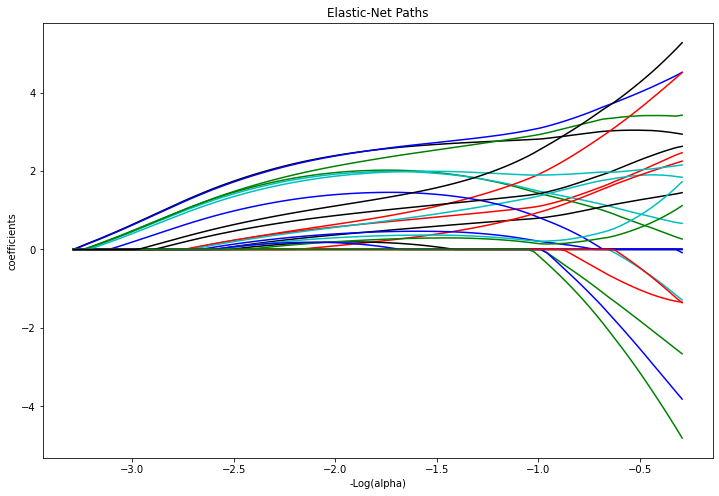

In [5]:
alphas_enet, coefs_enet, _ = fit.path(X,y)
# Plot 
plt.rcParams['figure.figsize'] = [12, 8]
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet[0], colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net Paths")
plt.axis("tight");